In [38]:
import os

wdir_m = '../results/20210801-1000it-1eps'
wdir_e = os.path.join(wdir_m, 'evaluation_10')

rew_file = os.path.join(wdir_e, 'ActionsRewards.txt')
results_file = os.path.join(wdir_e, 'ActionsPerEpisode.txt')
motor_file = os.path.join(wdir_e, 'MotorOutputs.txt')


conf_file = os.path.join(wdir_m, 'backupcfg_sim.json')

In [5]:
# Compied from `Observe Critic.ipynb`
import json

class MockAIGame:
    observations = []
    rewards = []
    env = None

    def __init__(self, env):
        self.env = env
    
config = None
with open('../config.json') as f:
    config = json.load(f)


import gym
env = gym.make('CartPole-v1')

from neurosim.game_interface import GameInterface

game = MockAIGame(env)
gi = GameInterface(game, config)


In [54]:
# extract the data

import csv
import json

motor = {}
with open(motor_file) as f:
    for row in csv.reader(f, delimiter='\t'):
        motor[row[0]] = [int(float(i)) for i in row[1:]]

steps = []

with open(rew_file) as f:
    for row in csv.reader(f, delimiter='\t'):
        t, move, critic, obs_space_j = row
#         print(obs_space_j)
        obs_space = json.loads(obs_space_j)
        game.observations = [obs_space]
        fr = gi.input_firing_rates()
        frind = (fr > 0).nonzero()
        steps.append({
            'move': move,
            'critic_run': float(critic),
            'critic': 
            'motor': motor[t] if len(steps) > 0 else [0,0],
            'obs': obs_space,
            'fr': list(frind[0])
        })

print('total steps: ', len(steps))
        
results = []
with open(results_file) as f:
    for row in csv.reader(f, delimiter='\t'):
        results.append(int(float(row[1])))
        
print('results:', len(results))
print('steps from results:', sum(results))

total steps:  8033
results: 24
steps from results: 7813


In [55]:
# separate by iteration

steps_seq = []

idx = 0
for r in results:
    steps_seq.append(steps[idx:idx+r])
    idx += r
    
print([len(s) for s in steps_seq])

[211, 500, 500, 197, 500, 81, 235, 307, 345, 188, 500, 240, 344, 121, 230, 381, 247, 500, 419, 97, 500, 486, 500, 184]


In [56]:
for s in steps_seq:
    print(s[-2])

{'move': '0.0', 'critic': -0.73952, 'motor': [3, 2], 'obs': [-1.1907861442852647, -0.8208725750161674, 0.19809805542063222, 1.1739129864315632], 'fr': [2, 21, 59, 78]}
{'move': '1.0', 'critic': -0.56343, 'motor': [1, 3], 'obs': [-0.9245501888685338, 0.9050119212542392, 0.05964666355148726, -0.5583231650494036], 'fr': [3, 39, 54, 64]}
{'move': '0.0', 'critic': 1.20707, 'motor': [6, 0], 'obs': [0.11535710983061902, -0.8635910047585998, -0.0452731384720687, -0.2953699618816748], 'fr': [10, 21, 45, 66]}
{'move': '1.0', 'critic': -0.61396, 'motor': [3, 5], 'obs': [-1.9280055215389686, -1.7397771931771862, -0.20187765093402688, -0.7091628691023091], 'fr': [0, 20, 40, 63]}
{'move': '1.0', 'critic': 0.45392, 'motor': [2, 4], 'obs': [-0.26798835726960984, 0.18721978620568608, 0.03235362994225614, -0.0822804699667185], 'fr': [7, 33, 52, 68]}
{'move': '0.0', 'critic': 0.73642, 'motor': [5, 1], 'obs': [-0.9091664824030803, -1.3961016658968206, -0.2045020412037015, -0.499207770067454], 'fr': [3, 20

In [57]:

critic_vals = []

for steps in steps_seq:
    vals = []
    if len(steps) == 500:
        for j in steps[:-1]:
            left, right = j['motor']
            if left != right:
                vals.append(j['critic'])
        critic_vals.append(vals)
    
print('steps for each 500eps run that are not unk:', [len(cv) for cv in critic_vals])

steps for each 500eps run that are not unk: [424, 420, 465, 420, 466, 415, 441]


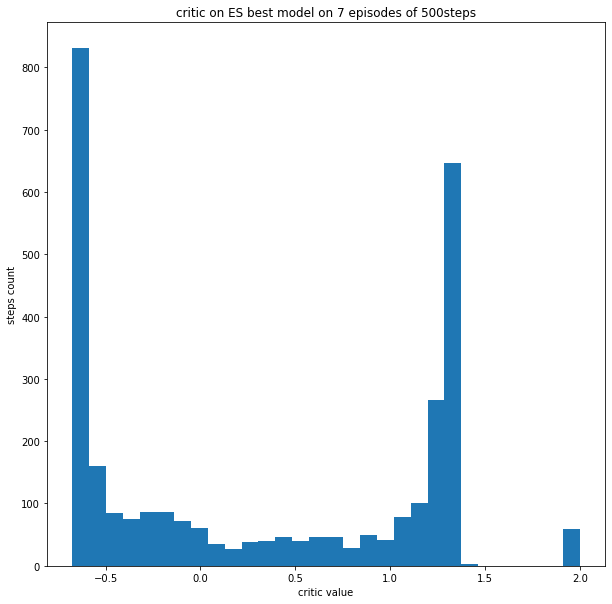

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.hist([v for cv in critic_vals for v in cv], bins=30)
plt.title('critic on ES best model on {} episodes of 500steps'.format(len(critic_vals)))
plt.xlabel('critic value')
plt.ylabel('steps count')
plt.show()

In [76]:
import numpy as np

print('Magnitude of average critic result', round(np.mean([v for cv in critic_vals for v in cv]), 3))
print('Magnitude of average critic result per episode', [round(np.mean(cv), 3) for cv in critic_vals])

print('--')

print('Ratio of reward/punishment', round(
    np.mean([1 if v > 0 else 0 for cv in critic_vals for v in cv]), 3))
print('Ratio of reward/punishment per episode', [round(np.mean([1 if v > 0 else 0 for v in cv]), 3) for cv in critic_vals])

Magnitude of average critic result 0.335
Magnitude of average critic result per episode [0.332, 0.335, 0.304, 0.338, 0.308, 0.342, 0.387]
--
Ratio of reward/punishment 0.526
Ratio of reward/punishment per episode [0.54, 0.529, 0.505, 0.531, 0.517, 0.53, 0.533]
